Following [here](https://statsthinking21.github.io/statsthinking21-python/08-HypothesisTesting.html)

[Other reference](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

In [2]:
# Import packages

import numpy as np
import pandas as pd
import scipy.stats as sds
import matplotlib.pyplot as plt

In [3]:
# Import talk data

# Load binary gendered talks 
talks_male = pd.read_csv('talks_male.csv', index_col='Talk_ID')
talks_female = pd.read_csv('talks_female.csv', index_col='Talk_ID')

# No one gender ==> NOG
talks_nog = pd.read_csv('talks_nog.csv', index_col='Talk_ID')

# Concatenate the talk data
all_talks = pd.concat([talks_male,talks_female,talks_nog])

In [4]:
# Import speaker data

speakers = pd.read_csv('speakers_with_gender.csv', index_col='speaker')

In [5]:
# Create list of events

events = list(all_talks['event'].unique())
events.sort()

cut_inds = events.index("TED2002")
events2test = events[cut_inds:]

## Ref: https://www.w3schools.com/python/ref_list_sort.asp
## Ref: https://www.programiz.com/python-programming/methods/list/index

In [6]:
def check_event(event_or_year):
    
    #Check if year is in list: 
    if str(event_or_year)[0] == 'T':
        event_name = event_or_year
    else: 
        event_name = 'TED' + str(event_or_year)
        
    assert (event_name in events), "There are no talks in our database from the requested year"
    
    return event_name

def extract_talks_by_event(event_or_year):
    
    event_name = check_event(event_or_year)
    event_talks = all_talks[all_talks['event'] == event_name]
    
    return event_talks

def extract_speakers_event(event_or_year):
    
    event_talk_array = extract_talks_by_event(event_or_year)
    event_speakers = event_talk_array[['speaker_1', 'speaker_2', 'speaker_3', 'speaker_4']]
    
    speaker_list = []
    
    for role in ['speaker_1', 'speaker_2', 'speaker_3', 'speaker_4']:
        event_speakers = event_talk_array[role].dropna()
        event_speakers = event_speakers.unique()
        speaker_list.extend(list(event_speakers))
        
    speaker_pd = pd.Series(speaker_list)
    speaker_pd = speaker_pd.unique()
    
    speaker_year = list(speaker_pd)
    ## Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
    
    return speaker_year
    
    
def prop_women_by_event(event_or_year):
    
    speaker_year = extract_speakers_event(event_or_year)
    
    gender_year = speakers.loc[speaker_year]
    gender_counts = gender_year.groupby(["Gender_handcheck"])["Gender_handcheck"].count()
    ## Ref: https://sparkbyexamples.com/pandas/pandas-groupby-count-examples/
    
    genders = list(gender_counts.index)
    if 'female' in genders: 
        total_single_speaker = gender_counts["male"] + gender_counts["female"]
        # Excluding groups of speakers (like a band or troupe)
        prop_women_single = gender_counts["female"]/total_single_speaker
    else: 
        total_single_speaker = gender_counts["male"]
        prop_women_single = 0.0
    
    return prop_women_single, total_single_speaker

## Need to edit so that it can handle no women

In [7]:
#Write function to loop over all the events. 

def all_events_prop(event_list):
    
    # preallocate the dataframe
    df_prop_w = pd.DataFrame(columns=['prop_w', 'Num_talks'], index=event_list)
    
    for event in event_list:
        df_prop_w.loc[event] = list(prop_women_by_event(event))
    
    return df_prop_w
## Ref: https://thispointer.com/pandas-how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-python/
    

In [8]:
# Create the sampling distributions

## Ref: https://statsthinking21.github.io/statsthinking21-python/08-HypothesisTesting.html

def generate_one_sample_prop(num_sample = 100, null_prop = 0.5):
    
    samp = np.random.rand(num_sample) > (1 - null_prop)
    return np.sum(samp)/num_sample

def generate_sampling_dist(num_runs = 5000, num_sample = 100, null_prop = 0.5):
    
    sampling_dist_df = pd.DataFrame({'props': np.zeros(num_runs)})
    
    for i in range(num_runs):
        sampling_dist_df.loc[i, 'props'] = generate_one_sample_prop(num_sample, null_prop)
        
    return sampling_dist_df



In [9]:
# Do the HT

## Ref: https://statsthinking21.github.io/statsthinking21-python/08-HypothesisTesting.html

def compute_p_val(obs_stat, null_prop = 0.5, H_a = "two-way", n = 100, num_runs = 5000, null_dist = False):
    
    if n < 10:
        return float("nan")
    
    if ~null_dist:
        null_dist = generate_sampling_dist(num_runs, n, null_prop)
    
    denom = null_dist.shape[0]
    if H_a == "less than":
        p_val = sum(null_dist["props"] < obs_stat)
        
    elif H_a == "greater than":
        p_val = sum(null_dist["props"] > obs_stat)
        
    elif H_a == "two-way":
        mirror_val = 2*null_prop - obs_stat
        if obs_stat > null_prop:
            left = sum(null_dist["props"] < mirror_val)
            right = sum(null_dist["props"] > obs_stat)
        elif obs_stat < null_prop:
            right = sum(null_dist["props"] > mirror_val)
            left = sum(null_dist["props"] < obs_stat)
        p_val = right + left
    
    return p_val/denom, null_dist

In [24]:
def compute_pval_all_events(event_df, null_prop_list = None, H_a = "two-way", num_runs = 1000):
    
    # Grab each row and run COMPUTE_P_VAL
    event_pval = event_df.copy()
    
    if null_prop_list == None:
        event_pval["null_prop"] = 0.5
    else:
        event_pval["null_prop"] = null_prop_list
    
    event_pval["p_val"] = event_pval.apply(lambda x: compute_p_val(x["prop_w"], \
                                                                   null_prop = x["null_prop"], \
                                                                   H_a = H_a, num_runs = num_runs, \
                                                                   n = x["Num_talks"])[0], axis = 1)
    return event_pval
## Ref: https://www.stackvidhya.com/add-column-to-dataframe/

In [28]:
# Create the visualizations 

def make_plot(null_dist, prop_women, null_prop = 0.5, H_a = "two-way"):
    
    # Create visualization for the sampling distribution
    bins = np.linspace(0,1,60)
    plt.hist(null_dist, bins, density=False, alpha=0.5, label = "sampling dist")
    
    # Mark the sample proportion
    plt.plot(prop_women, 1, 'o', color = 'k')
    
    # Add annotations for the plots
    plt.axvline(x=prop_women, ymin=0, color='red', linestyle='dotted', linewidth=1)
    if H_a == "two-way":
        mirror_val = 2*null_prop-prop_women
        plt.axvline(x=mirror_val, ymin=0, color='blue', linestyle='dotted', linewidth=1)
    
    plt.show()

In [17]:
event_df = all_events_prop(events2test)

In [18]:
event_df

,prop_w,Num_talks
TED2002,0.185185,27
TED2003,0.1875,32
TED2004,0.21875,32
TED2005,0.135135,37
TED2006,0.232558,43
TED2007,0.230769,65
TED2008,0.22807,57
TED2009,0.246914,81
TED2010,0.223881,67
TED2011,0.211268,71


In [16]:
event_df

,prop_w,Num_talks,null_prop
TED2002,0.185185,27,0
TED2003,0.1875,32,1
TED2004,0.21875,32,2
TED2005,0.135135,37,3
TED2006,0.232558,43,4
TED2007,0.230769,65,5
TED2008,0.22807,57,6
TED2009,0.246914,81,7
TED2010,0.223881,67,8
TED2011,0.211268,71,9


In [25]:
event_out = compute_pval_all_events(event_df)

In [26]:
event_out

,prop_w,Num_talks,null_prop,p_val
TED2002,0.185185,27,0.5,0.000
TED2003,0.1875,32,0.5,0.000
TED2004,0.21875,32,0.5,0.000
TED2005,0.135135,37,0.5,0.000
TED2006,0.232558,43,0.5,0.000
TED2007,0.230769,65,0.5,0.000
TED2008,0.22807,57,0.5,0.000
TED2009,0.246914,81,0.5,0.000
TED2010,0.223881,67,0.5,0.000
TED2011,0.211268,71,0.5,0.000


In [58]:
event_dftest = event_df.copy()

In [39]:
event_dftest["p_val"] = "Nan"

In [66]:
event_dftest.apply(lambda x: print(compute_p_val(x["prop_w"])[0]), axis = 1)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0038
0.0024
0.0828


TED2002    None
TED2003    None
TED2004    None
TED2005    None
TED2006    None
TED2007    None
TED2008    None
TED2009    None
TED2010    None
TED2011    None
TED2012    None
TED2013    None
TED2014    None
TED2015    None
TED2016    None
TED2017    None
dtype: object

In [83]:
event_dftest


,prop_w,Num_talks,p_val
TED2002,0.185185,27,0.0004
TED2003,0.1875,32,0.0000
TED2004,0.21875,32,0.0006
TED2005,0.135135,37,0.0000
TED2006,0.232558,43,0.0002
TED2007,0.230769,65,0.0000
TED2008,0.22807,57,0.0000
TED2009,0.246914,81,0.0000
TED2010,0.223881,67,0.0000
TED2011,0.211268,71,0.0000


In [78]:
print(compute_p_val(0.36, n=75)[0])

0.0134


In [9]:
## Tests

year = 2007

In [10]:
prop_w, total = prop_women_by_year(year)

In [11]:
sampling_dist = generate_sampling_dist(num_runs = 1000, num_sample = 65, null_prop = 0.5)

In [12]:
sampling_dist.shape

(1000, 1)

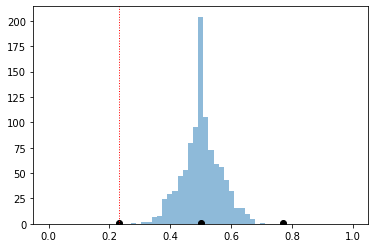

In [27]:
bins = np.linspace(0,1,60)
plt.hist(sampling_dist, bins, density=False, alpha=0.5, label = "sampling dist")
plt.plot(prop_w, 1, 'o', color = 'k')
plt.plot(1-prop_w, 1, 'o', color = 'k')
plt.plot(0.5, 1, 'o', color = 'k')
plt.axvline(x=prop_w, ymin=0, color='red', linestyle='dotted', linewidth=1)
plt.show()

#add single point!

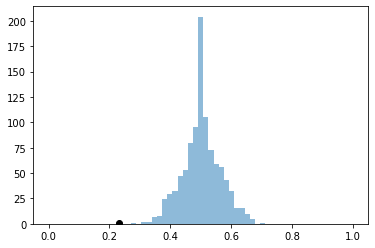

In [14]:
make_plot(sampling_dist, prop_w)

In [34]:
p_val, null_dist = compute_p_val(prop_w, null_prop = 0.25, H_a = "two-way", n = 65)


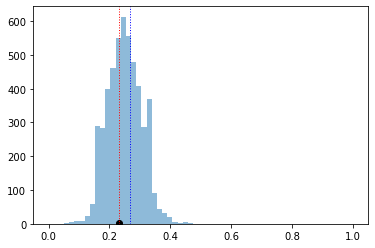

In [33]:
make_plot(null_dist, prop_w, null_prop = 0.25)

In [35]:
print(p_val)

0.6638


In [5]:
year = '2007'
event_name = 'TED' + str(year)
event_name

'TED2007'

In [6]:
event_year = all_talks[all_talks['event'] == 'TED2007']


In [11]:
speaker_list = extract_speakers_by_year(2007)

# How to check if the list is unique?? Extend somehow? 
# Done see above

In [16]:
gender_year = speakers.loc[speaker_list]
gender_counts = gender_year.groupby(["Gender_handcheck"])["Gender_handcheck"].count()

gender_counts["male"]

50

In [13]:
gender_counts.sum()

66

In [17]:
gender_counts["male"], gender_counts["female"]

(50, 15)